In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision.transforms import ToPILImage

In [80]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convierte imágenes a tensores de PyTorch
    transforms.Normalize((0.5,), (0.5,))  # Normaliza entre -1 y 1
])

train_dataset = datasets.MNIST(
    root='./data',        # Carpeta donde se descargará
    train=True,           # Datos de entrenamiento
    transform=transform,  # Transformaciones definidas antes
    download=True         # Descarga si no está presente
)

test_dataset = datasets.MNIST(
    root='./data',        # Carpeta donde se descargará
    train=False,          # Datos de prueba
    transform=transform,  # Transformaciones definidas antes
    download=True         # Descarga si no está presente
)

subset_size = 1000
rest_size = len(train_dataset) - subset_size
train_dataset, rest = random_split(train_dataset, [subset_size, rest_size])

In [81]:
# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [82]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,dataset,transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self,index):
        img0, label0 = random.choice(self.dataset)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1, label1 = random.choice(self.dataset)
                if label0 == label1:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1, label1 = random.choice(self.dataset)
                if label0 != label1:
                    break

        img0 = ToPILImage()(img0)
        img1 = ToPILImage()(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(label0 != label1)], dtype=np.float32))

    def __len__(self):
        return len(self.dataset)

In [83]:
siamese_dataset = SiameseNetworkDataset(dataset=train_dataset,transform=transform)

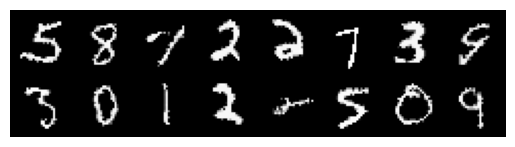

[1. 1. 1. 0. 0. 1. 1. 0.]


In [84]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same number, label is 0, same number in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [85]:
#create the Siamese Neural Network
class SiameseModel(nn.Module):
  def __init__(self, encoder):
    super(SiameseModel, self).__init__()
    encoder[0] = nn.Conv2d(1, 64, kernel_size=7,
                                   stride=2, padding=3, bias=False)
    self.encoder = encoder
    self.head = nn.Sequential(
          nn.Linear(512, 2)
      )

  def forward_once(self, x):
    # This function will be called for both images
    # Its output is used to determine the similiarity
    output = self.encoder(x)
    output = output.view(output.size()[0], -1)
    output = self.head(output)
    return output

  def forward(self, input1, input2):
      output1 = self.forward_once(input1)
      output2 = self.forward_once(input2)

      return output1, output2

In [86]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [87]:
resnet18 = torchvision.models.resnet18(pretrained=True)
backbone = nn.Sequential(*list(resnet18.children())[:-2])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [96]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

net = SiameseModel(encoder = backbone)
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [76]:
print(len(train_dataset))

1000


Epoch number 0
 Current loss 0.016363872215151787

Epoch number 1
 Current loss 0.07309150695800781

Epoch number 2
 Current loss 0.04653388261795044

Epoch number 3
 Current loss 0.03625009208917618

Epoch number 4
 Current loss 0.013576401397585869

Epoch number 5
 Current loss 0.017297610640525818

Epoch number 6
 Current loss 0.038379691541194916

Epoch number 7
 Current loss 0.06748921424150467

Epoch number 8
 Current loss 0.024903053417801857

Epoch number 9
 Current loss 0.05539580434560776

Epoch number 10
 Current loss 0.031671974807977676

Epoch number 11
 Current loss 0.024733079597353935

Epoch number 12
 Current loss 0.0551130548119545

Epoch number 13
 Current loss 0.04904237017035484

Epoch number 14
 Current loss 0.06690461188554764

Epoch number 15
 Current loss 0.13885103166103363

Epoch number 16
 Current loss 0.041113704442977905

Epoch number 17
 Current loss 0.035258255898952484

Epoch number 18
 Current loss 0.04594219848513603

Epoch number 19
 Current loss 0.0

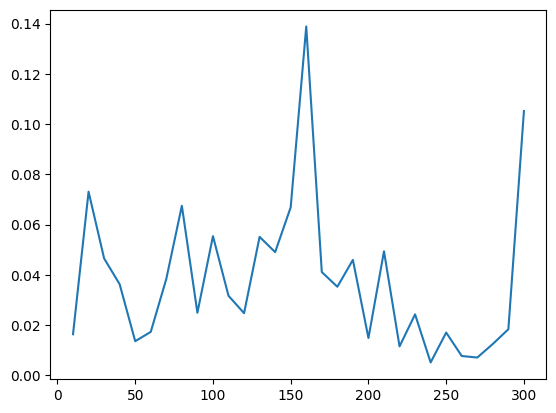

In [90]:
counter = []
loss_history = []
iteration_number= 0

# Iterate throught the epochs
for epoch in range(10):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader):

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 1000 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

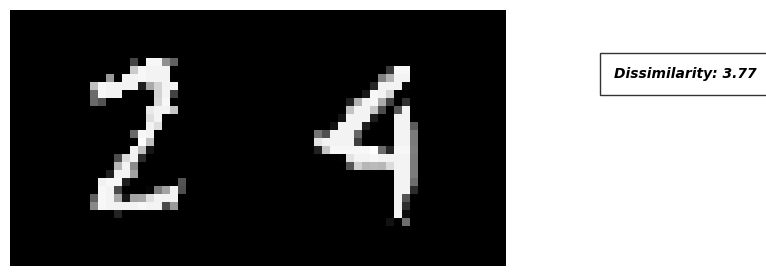

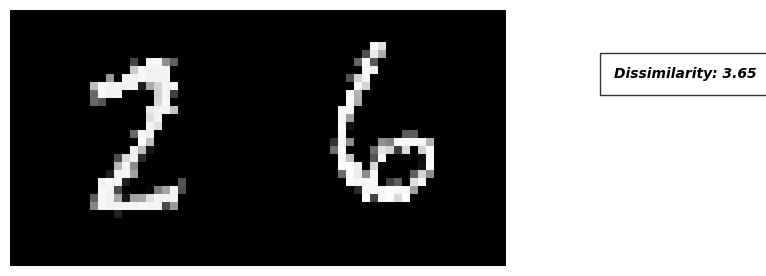

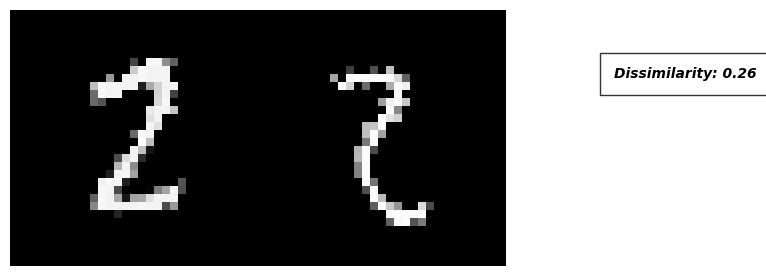

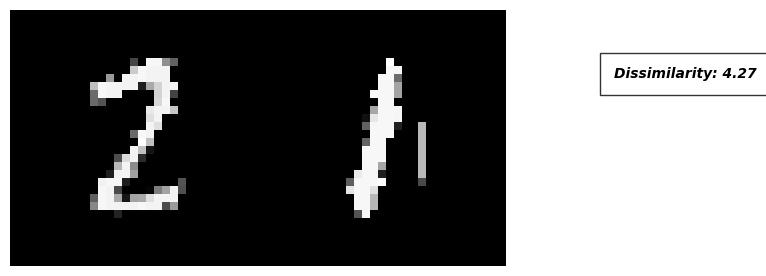

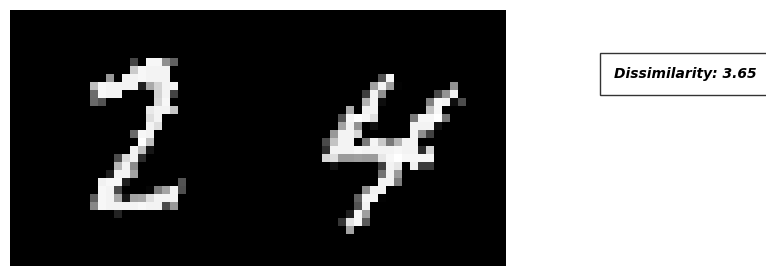

In [95]:
test = SiameseNetworkDataset(dataset=test_dataset,transform=transform)
test_dataloader = DataLoader(test, num_workers=2, batch_size=1, shuffle=True)

dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)
net.eval()

for i in range(5):
    # Iterate over 5 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)

    output1, output2 = net(x0, x1)
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')